In [1]:
%config Completer.use_jedi = False
%matplotlib inline

import numpy as np
import matplotlib as mpl 
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean as cmo
import os.path
import nc_time_axis

mpl.rcParams['figure.figsize'] = 12, 8
mpl.rcParams['font.size'] = 16

## Load netCDF file into xarray Dataset

In [2]:
dfile = '/home/disk/eos15/apauling/seaice/nsidc_sic.nc'

ds = xr.open_dataset(dfile)
ds

<xarray.Dataset>
Dimensions:    (time: 446, x: 304, y: 448)
Coordinates:
  * x          (x) int64 0 1 2 3 4 5 6 7 8 ... 296 297 298 299 300 301 302 303
  * y          (y) int64 0 1 2 3 4 5 6 7 8 ... 440 441 442 443 444 445 446 447
    lat        (x, y) float64 ...
    lon        (x, y) float64 ...
  * time       (time) datetime64[ns] 1978-11-01 1978-12-01 ... 2015-12-01
    hole_mask  (time, y, x) bool ...
Data variables:
    sic        (time, x, y) float64 ...

## Load sea ice concentration into a DataArray from the Dataset 

In [3]:
sic = ds['sic']
sic

<xarray.DataArray 'sic' (time: 446, x: 304, y: 448)>
[60741632 values with dtype=float64]
Coordinates:
  * x          (x) int64 0 1 2 3 4 5 6 7 8 ... 296 297 298 299 300 301 302 303
  * y          (y) int64 0 1 2 3 4 5 6 7 8 ... 440 441 442 443 444 445 446 447
    lat        (x, y) float64 ...
    lon        (x, y) float64 ...
  * time       (time) datetime64[ns] 1978-11-01 1978-12-01 ... 2015-12-01
    hole_mask  (time, y, x) bool ...

### Show the dimensions of the DataArray

In [4]:
print(sic.dims)

('time', 'x', 'y')


### Show the coordinates of the DataArray

In [5]:
print(sic.coords)

Coordinates:
  * x          (x) int64 0 1 2 3 4 5 6 7 8 ... 296 297 298 299 300 301 302 303
  * y          (y) int64 0 1 2 3 4 5 6 7 8 ... 440 441 442 443 444 445 446 447
    lat        (x, y) float64 ...
    lon        (x, y) float64 ...
  * time       (time) datetime64[ns] 1978-11-01 1978-12-01 ... 2015-12-01
    hole_mask  (time, y, x) bool ...


## Make the plot
- initialize the figure
- create the axes for the plot to go in, specifying the projection that you __want the plot to be in__
- the axes you created are now a GeoAxes object, a class from the `cartopy` module, that have mapping specific methods you can call, such as putting in the coastlines
- set the extent of the plot. PlateCarree seems to be the projection to specify if you're not sure of your data's projection
- use the built in `xarray` plotting functionality to plot. Specify the `x` and `y` dimensions as strings, the axis to put the plot in, and the projection __of the data__  



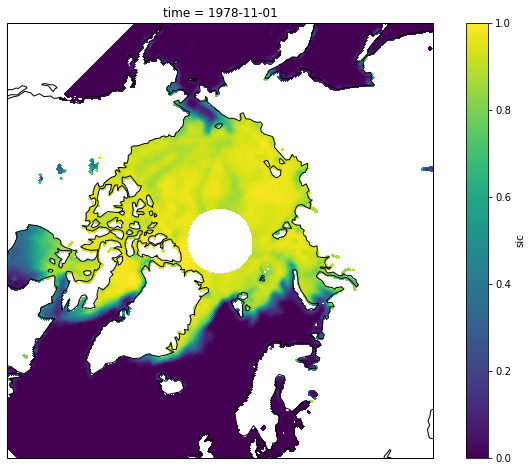

In [6]:
fig = plt.figure(1, figsize=(12, 8))
axs = plt.axes(projection=ccrs.NorthPolarStereo())
axs.coastlines()
axs.set_extent([-180, 180, 55, 90], crs=ccrs.PlateCarree())
sic[0, :, :].plot.pcolormesh('lon', 'lat', ax=axs, transform=ccrs.PlateCarree())

## Make a nice circular boundary
You can also make a circular boundary using the code below. It is ugly, and basemap had a far nicer way to do this, but it is possible in cartopy. Unfortunately you cannot currently label the gridlines in cartopy in a polar stereographic projection.

Here I've also used a nice sea ice colormap from the cmocean package (https://matplotlib.org/cmocean/), and changed the colorbar label to something more informative.  
I've also filled in the land which, again, was much less clunky in basemap, but is done in cartopy using the `feature` submodule 

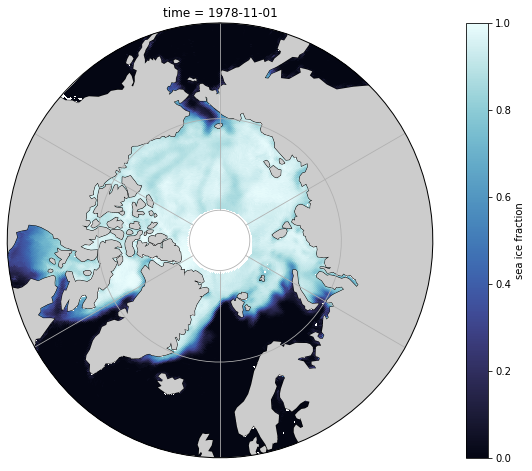

In [7]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

fig = plt.figure(1, figsize=(12, 8))
axs = plt.axes(projection=ccrs.NorthPolarStereo())
axs.coastlines()
gl = axs.gridlines(draw_labels=False, xlocs=None, ylocs=[55, 70, 85])
gl.n_steps = 90
axs.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', facecolor='0.8'))
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
axs.set_boundary(circle, transform=axs.transAxes)
axs.set_extent([-180, 180, 55, 90], crs=ccrs.PlateCarree())
sic[0, :, :].plot.pcolormesh('lon', 'lat', ax=axs, transform=ccrs.PlateCarree(),
                             cmap=cmo.cm.ice, cbar_kwargs={'label': 'sea ice fraction'})

## Lets compute Antarctic sea ice area and plot it using just xarray

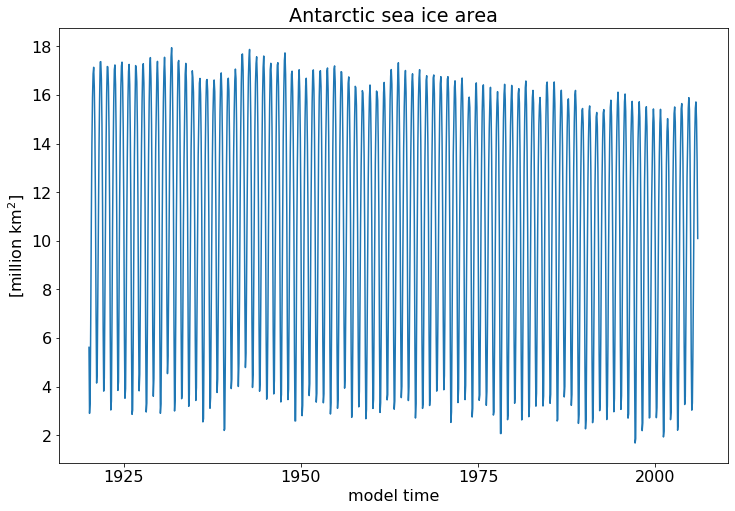

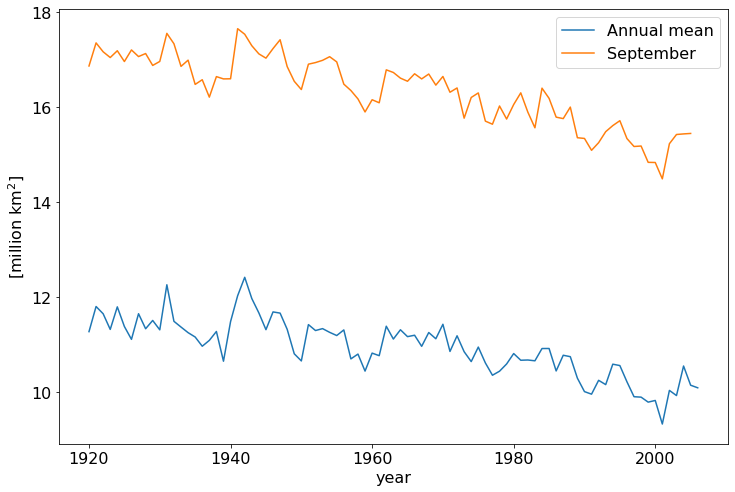

In [37]:
mpl.rcParams['figure.figsize'] = 12, 8
mpl.rcParams['font.size'] = 16

# Open the CESM data into an xarray Dataset
ddir = '/home/disk/eos15/apauling/seaice'
dfile = 'b.e11.B20TRC5CNBDRD.f09_g16.005.cice.h.aice_sh.192001-200512.nc'
ncF = os.path.join(ddir, dfile)
ds = xr.open_dataset(ncF)

# Get out the ice fraction and grid cell area, then multiply them. Xarray is smart enough to figure out
# that you want to multiply at every time, since the dimension names of area match those in aice, so you
# don't need to create a new time dimension for the area like you would in MATLAB
aice = ds['aice']/100
area = ds['tarea']
siarea = aice*area/1e12

# Compute the sea ice area by summing over the dimensions associated with lat and lon.
# For CESM these are called 'nj' and 'ni'
si_tseries = siarea.sum(dim=('nj', 'ni'))

fig = plt.figure(1)
si_tseries.plot()
plt.title('Antarctic sea ice area')
plt.ylabel('[million km$^2$]')

# Now lets plot the annual mean by grouping the timeseries by year and then averaging over time.
# This makes the dimension of the variable 'year' rather than 'time'
siANN = si_tseries.groupby('time.year').mean('time')
siANN = siANN.rename({'year': 'time'})

# Now let's just do September
si_sept = si_tseries.sel(time=slice('1920-09', '2005-09', 12))
# Hack to make the x-coordinate the same as the annual mean,
# otherwise they don't plot on the same figure nicely
si_sept = si_sept.groupby('time.year').mean(dim='time')

fig2 = plt.figure(2)
siANN.plot(label='Annual mean')
si_sept.plot(label='September')
plt.ylabel('[million km$^2$]')
plt.legend()

## Just for fun

`cartopy` also has functions for pulling in and plotting satellite imagery from a "web map tile service". NASA has one of these, find more info at http://earthdata.nasa.gov:443/eosdis/science-system-description/eosdis-components/gibs. 

Good luck though. I found both the NASA website and the functions in cartopy poorly documented and difficult to use.

There are some examples here:  
https://scitools.org.uk/cartopy/docs/v0.15/examples/wmts.html
https://scitools.org.uk/cartopy/docs/v0.15/examples/wmts_time.html  
but they're pretty sparse.

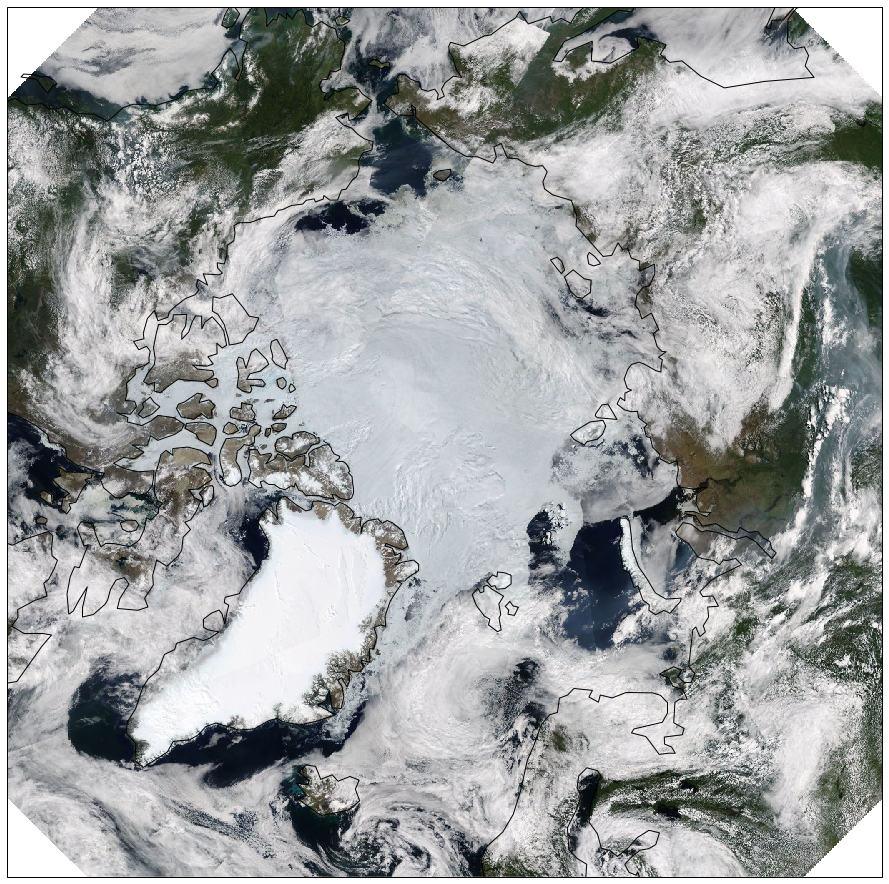

In [8]:
fig = plt.figure(1, figsize=(24, 16))
axs = plt.axes(projection=ccrs.NorthPolarStereo())
base_url = 'https://gibs.earthdata.nasa.gov/wmts/epsg3413/best/wmts.cgi'
layer_name = 'MODIS_Terra_CorrectedReflectance_TrueColor'
axs.add_wmts(base_url, layer_name=layer_name, wmts_kwargs={'time': '2019-07-05'})
axs.coastlines()
axs.set_extent((-180, 180, 60, 90), crs=ccrs.PlateCarree())

In [1]:
import cftime
cftime.__version__

'1.0.3.4'